## CNN: Classifying X-ray images

In the notebook below, we will be building convolutional neural networks to classify X-ray images of lungs in the hopes of identifying those lungs that show signs of pneumonia. We will ultimately classify the lungs as either "Normal" or "Pnuemonia." Numerically, these classes will be represented as 0 (for Normal) and 1 (for Pneumonia), respectively.

**Note:** You can greatly improve the computation speed in Google Colab by connecting to a GPU. Click the "Runtime" tab in the top ribbon, then "Change runtime type". You can then select "T4 GPU". Note, however, that GPUs are subject to availability; Google has a fixed (and unspecified) amount of resources available at any given time, so a GPU may not be available. Feel free to try again later if you don't succeed at first.

## Libraries to Import

In [ ]:
!pip install tensorflow==2.18.0
!pip install keras==3.8.0
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import numpy as np
import random
import tensorflow as tf
import pickle

**Real quick**: make sure tensorflow and keras are version 2.18.0 and 3.8.0, respectively by running the cells below.

If either is showing the wrong version, restart the session by clicking the "Runtime" tab up top and selecting "Restart session". After that, run the notebook again from the top.

In [ ]:
!pip show tensorflow #Should be version 2.18.0

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:
!pip show keras #Should be version 3.8.0

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [ ]:
def set_random_seed():
  seed = 118
  # Set random seeds for reproducibility
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # (For TensorFlow GPU determinism)
  os.environ['CUDA_VISBLE_DEVICE'] = ''
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['PYTHONHASHSEED'] = str(1234)

## Part 1: Loading the Image Data

In [ ]:
#Run this cell, but DO NOT EDIT
def get_data(pkl_path):
    with open(pkl_path, 'rb') as f:
      # Read the data from the file
      data = pickle.load(f)
    return data

In [ ]:
#Run this cell, but DO NOT EDIT

train = get_data("chest_xray_train.pkl")
test = get_data("chest_xray_test.pkl")
val = get_data("chest_xray_val.pkl")

Just for fun, run the code below to see a sample image. Note that `train[i][0] `returns the i-th training image array and `train[i][1]` returns the label (0 for Normal or 1 for Pneumonia) corresponding to the i-th training image:

Label = 0


array([[38, 34, 36, ..., 67, 56, 55],
       [41, 43, 43, ..., 61, 56, 54],
       [43, 46, 44, ..., 55, 56, 55],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
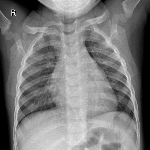

In [ ]:
print(f"Label = {train[0][1]}")
train[0][0]

## Part 2: Data Preparation

As noted above, the image data and labels are both part of the same master array (the train, test, or val arrays). In order to prepare things for neural networks, we need to split up the images from their labels. We will call the image arrays our x values and their respective labels our y values.

`train[i][0]` returns the i-th training image array and `train[i][1]` returns the label (0 for Normal or 1 for Pneumonia) corresponding to the i-th training image.



In [ ]:
x_train = [train[i][0] for i in range(len(train))]
y_train = [train[i][1] for i in range(len(train))]

x_val = [val[i][0] for i in range(len(val))]
y_val = [val[i][1] for i in range(len(val))]

x_test = [test[i][0] for i in range(len(test))]
y_test = [test[i][1] for i in range(len(test))]

All the image arrays contain values between 0 and 255. In preperation for inputting this data into a neural network, we need to normalize these values so that they are between 0 and 1 instead.

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

As a final bit of data prep, we need to do two things:


1.   Reshape `x_train`, `x_val`, and `x_test` such that they are a numpy array of shape (|x|, 150, 150, 1), where |x| is the number of images in each array. For example, if done correctly, `x_train` should be a numpy array of shape (5216, 150, 150, 1) since |`x_train`| is 5216 (i.e. there are 5216 images in `x_train`)
2.   Convert `y_train`, `y_val`, and `y_test` to numpy arrays. We do not need to reshape these arrays because they are just one dimensional lists of zeros and ones.



In [ ]:
#TODO: Reshape x_train, x_val, and x_test such that they are numpy arrays of shape (|x|, 150, 150, 1)
x_train = x_train.reshape(x_train.shape[0], 150, 150, 1)
x_val = x_val.reshape(x_val.shape[0], 150, 150, 1)
x_test = x_test.reshape(x_test.shape[0], 150, 150, 1)

In [ ]:
#TODO: Convert y_train, y_val, and y_test to numpy arrays.
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

We now have our data prepped and ready to go. All of our x arrays contain normalized 150x150 images with a single channel. Note that if we were using RGB images, our x arrays would need to be of shape (|x|, 150, 150, 3), where 3 represents the red, green, and blue channels.

Likewise, our y labels are in a nice one-dimensional numpy array since they are just a series of zeros and ones.

We are now ready to build our convolutional neural network.

## Part 3a: Building a Basic CNN

Keras is a powerful and user-friendly deep learning library authored by Google. It acts as a high-level API, making it easier to build and train various neural network architectures.

In the cell below, you'll note that things begin with `model = keras.Sequential()`. Here, `Sequential()` creates a sequential model object that defines how layers are stacked and connected within the model.

In [ ]:
set_random_seed()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

We are now ready to train our model.

*   Before training, we specify the number of training epochs to be used and the batch size needed for training.
*   Note that we are exclusively using `x_train` and `y_train` during training. We will save `x_test` and `y_test` for the end as a means to evaluate our model. In the meantime, we can use `x_val` and `y_val` to observe how performance improves/worsens over the epochs.
*   Training may take a while (depending on your model, it could take about an hour). Connecting to a GPU can dramatically improve performance, however.



In [ ]:
num_epochs = 15
batch_size = 32

model.fit(x = x_train, y = y_train, epochs= num_epochs, validation_data = (x_val, y_val), batch_size = batch_size)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - binary_accuracy: 0.8343 - loss: 0.3711 - precision_1: 0.8456 - recall_1: 0.9522 - val_binary_accuracy: 0.8125 - val_loss: 0.2828 - val_precision_1: 1.0000 - val_recall_1: 0.6250
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.9509 - loss: 0.1359 - precision_1: 0.9648 - recall_1: 0.9685 - val_binary_accuracy: 1.0000 - val_loss: 0.0913 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.9738 - loss: 0.0756 - precision_1: 0.9829 - recall_1: 0.9814 - val_binary_accuracy: 1.0000 - val_loss: 0.1534 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - binary_accuracy: 0.9771 - loss: 0.0720 - precision_1: 0.9869 - recall_1: 0.9820 - val_binary_accuracy: 1.0000 - val_loss: 0.0615 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - binary_accura

## Part 3b: Evaluate the Basic CNN

It's time to generate predictions and evaluate our model. To do so, run the cell below. You should be able to achieve accuracy scores >= 75%. If not, try a different approach, retrain your model, and return here to check the results.

In [ ]:
results = model.evaluate(x_test,y_test)
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Sensitivity: {results[3]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5466 - loss: 6.5869 - precision_1: 0.3612 - recall_1: 0.6651
Accuracy: 0.7516025900840759
Precision: 0.7179962992668152
Sensitivity: 0.9923076629638672


Save our model as follows:

1.   Mount your Google Drive to this notebook by running the cell below. This will allow you to save your models within this Colab Notebook to your Google Drive.
2.   Decide where in your Drive you would like to save your model. You will need to construct a file path to this location. For example, "drive/MyDrive/EAS5860/"
3.   Populate the `path` variable in the second cell below with your desired file path and run the cell to save your model.



In [ ]:
#Run this cell to mount your Google Drive (click through pop-up windows to authenticate)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/"

model.save(os.path.join(path, "EAS5860_HW4_Part_3.keras"))

##Part 4a: Dropout Layers

You may have noticed during the training of your CNN above that the model performs better on the training data than it does on the testing data. When a model performs well on training data, but fails to generalize well on unseen data, we say that the model is "overfit".

One way to prevent overfitting is to include dropout layers within the network.

1.   .   Note the effect of the Dropout Layer(s) on the model's performance. It may or may not improve the Accuracy, Precision, or Sensitivity. Experiment with different configurations.









In [ ]:
set_random_seed()

model_dropout = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
model_dropout.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 15
batch_size = 32

model_dropout.fit(x = x_train, y = y_train, epochs= num_epochs, validation_data = (x_val, y_val), batch_size = batch_size)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - binary_accuracy: 0.8212 - loss: 0.4179 - precision_2: 0.8255 - recall_2: 0.9692 - val_binary_accuracy: 0.7500 - val_loss: 0.6002 - val_precision_2: 0.6667 - val_recall_2: 1.0000
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.9627 - loss: 0.1134 - precision_2: 0.9712 - recall_2: 0.9784 - val_binary_accuracy: 1.0000 - val_loss: 0.1135 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - binary_accuracy: 0.9664 - loss: 0.1042 - precision_2: 0.9766 - recall_2: 0.9778 - val_binary_accuracy: 1.0000 - val_loss: 0.0712 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9742 - loss: 0.0710 - precision_2: 0.9844 - recall_2: 0.9805 - val_binary_accuracy: 1.0000 - val_loss: 0.0399 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accura

## Part 4b: Evaluate the CNN With Dropout Layers

Run the cell below to evaluate your Dropout model. Did your addition of Dropout Layers affect the performance in any substantial way? Try different configurations, layer sizes, etc. and observe the effect on the evaluation metrics.

In [ ]:
results = model_dropout.evaluate(x_test,y_test)
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Sensitivity: {results[3]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.5285 - loss: 5.6030 - precision_2: 0.3568 - recall_2: 0.6664
Accuracy: 0.7467948794364929
Precision: 0.7124541997909546
Sensitivity: 0.9974358677864075


When you're ready, save your model:


In [ ]:
path = "drive/MyDrive/" #(Ex: "drive/MyDrive/EAS5860/HW4")

model_dropout.save(os.path.join(path, "EAS5860_HW4_Part_4.keras"))

## Part 5a: Data Augmentation

The quality of any convolutional neural network is limited to the both quality and *quantity* of the available training data. Unfortunately, additional training data is not always available. In such scenarios, we turn to Data Augmentation.

Data Augmentation is the process of artifically enhancing the size of our training data set by taking existing images and transforming them (stretching, cropping, mirroring, etc.) to create "new" training images. We then train our model on the full set of original images as well as the augmented images in the hopes of improving performance.

Qe will be using Keras's ImageDataGenerator for Data Augmentation.

In the cell below, populate the ImageDataGenerator to achieve the following data augmentations:

*   Rotate images by up to 30 degrees
*   Zoom in/out by a factor of 0.2
*   Shift the image horizontally (width-wise) by a factor of 0.1
*   Shift the image vertically (height-wise) by a factor of 0.1
*   Introduce a horizontal flip





In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
  )

datagen.fit(x_train)

Below is the same model from Part 3, just under a new name. We will be training this model again, but with our expanded and augmented data set.

As in Part 3/4, add additional layers to the model below. The accuracy goal for this model will be >= 90%.

In [ ]:
set_random_seed()

aug_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

aug_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

We will now train the model. Note the use of `datagen.flow()` in the cell below. This both generates our augmented images (as specified in our `datagen` object) and passes them batch-wise to our model for training.

In the cell below, specify the number of epochs and the batch size before training via `aug_model.fit()`

In [ ]:
num_epochs = 18
batch_size = 32

aug_model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,epochs = num_epochs , validation_data = datagen.flow(x_val, y_val))

Epoch 1/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - binary_accuracy: 0.7637 - loss: 0.5754 - precision_5: 0.7704 - recall_5: 0.9787 - val_binary_accuracy: 0.8125 - val_loss: 0.6526 - val_precision_5: 0.7273 - val_recall_5: 1.0000
Epoch 2/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - binary_accuracy: 0.8649 - loss: 0.3240 - precision_5: 0.8930 - recall_5: 0.9295 - val_binary_accuracy: 0.7500 - val_loss: 0.7617 - val_precision_5: 0.6667 - val_recall_5: 1.0000
Epoch 3/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - binary_accuracy: 0.9009 - loss: 0.2488 - precision_5: 0.9330 - recall_5: 0.9342 - val_binary_accuracy: 0.6250 - val_loss: 1.5229 - val_precision_5: 0.5714 - val_recall_5: 1.0000
Epoch 4/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - binary_accuracy: 0.8994 - loss: 0.2328 - precision_5: 0.9321 - recall_5: 0.9326 - val_binary_accuracy: 0.6250 - val_loss: 1.2955 - val_precision_5: 0.5714 - val_recall_5: 1.0000
Epoch 5/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - bin

## Part 5b: Evaluate the CNN Trained on Augmented Data

It's time to once again generate predictions and evaluate our model. To do so, run the cell below. Thanks to data augmentation, you should be able to achieve accuracy scores >= 90%. If not, try adjusting the placement/composition of your Conv2D, MaxPooling, or DropOut layers. Also consider adjusting your epochs/batch size.

In [ ]:
results = aug_model.evaluate(x_test,y_test)
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Sensitivity: {results[3]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.8867 - loss: 0.4520 - precision_5: 0.5270 - recall_5: 0.6437
Accuracy: 0.9198718070983887
Precision: 0.9086538553237915
Sensitivity: 0.9692307710647583


When you're pleased with your results, save your model as before:


In [ ]:
path = "drive/MyDrive/" #(Ex: "drive/MyDrive/EAS5860/HW4")

aug_model.save(os.path.join(path, "EAS5860_HW4_Part_5.keras"))

# Good Work!

Feel free to return here to try out new experiments in the future!